In [1]:
import yaml

import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.transform import resize

import torch
import torch.nn as nn
import torch.nn.functional as F
from yolov7.utils.loss import ComputeFineGrainedFeatureImitationLoss, ComputeKDLoss, ComputeLoss, bbox_iou
from yolov7.utils.general import xywh2xyxy
from yolov7.utils.torch_utils import intersect_dicts
from yolov7.distillate import load_teacher, create_dataset_dataloader
from yolov7.models.yolo import DistillationType, Model
from vision_data_engine.utils.visualization import draw_labels_to_image
from vision_data_engine.utils.general import get_class_names


In [2]:
class Args: 
    teacher_weights =  "/media/magalhaes/vision/pretrained/yolov7x_training.pt"
    teacher_cfg = "./cfg/training/yolov7x.yaml"
    batch_size = 6
    workers = 0
    single_cls = False
    cfg = "./cfg/training/yolov7-tiny.yaml"

args = Args()
num_classes = 80
names = get_class_names("./data/coco.yaml")

In [4]:
with open("./data/hyp.distillation.tiny.yaml") as f:
    hyp = yaml.load(f, Loader=yaml.SafeLoader)  # load hyps

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = load_teacher(
    args.teacher_weights,
    args.teacher_cfg,
    num_classes,
    device,
    distillation_type=DistillationType.HEAD,
)
grid_size = grid_size = max(int(model.stride.max()), 32)


Transferred 642/644 items from /media/magalhaes/vision/pretrained/yolov7x_training.pt


In [16]:
student = Model(
    args.cfg,
    ch=3,
    nc=num_classes,
    anchors=hyp.get("anchors"),
    distillation_type=DistillationType.HEAD,
).to(device)
ckpt = torch.load(
    "/media/magalhaes/vision/pretrained/yolov7-tiny.pt", map_location=device
)
exclude = ["anchor"]  # exclude keys
state_dict = ckpt["model"].float().state_dict()  # to FP32
state_dict = intersect_dicts(
    state_dict, student.state_dict(), exclude=exclude
)  # intersect
student.load_state_dict(state_dict, strict=False)  # load
num_detection_layers = student.model[-1].nl
hyp["box"] *= 3.0 / num_detection_layers  # scale to layers
hyp["cls"] *= (
    num_classes / 80.0 * 3.0 / num_detection_layers
)  # scale to classes and layers
hyp["obj"] *= (
    (640 / 640) ** 2 * 3.0 / num_detection_layers
)  # scale to image size and layers
student.nc = num_classes  # attach number of classes to model
student.hyp = hyp  # attach hyperparameters to model
student.gr = 1.0  # iou loss ratio (obj_loss = 1.0 or iou)

In [7]:
train_dataloader, train_dataset, num_batches = create_dataset_dataloader(
    args, "/home/guests2/msg/coco/val2017.txt", grid_size, 640, True, hyp, num_classes
)

distil: Scanning '/home/guests2/msg/coco/val2017.cache' images and labels... 4952 found, 48 missing, 0 empty, 0 corrupted: 100%|██████████| 5000/5000 [00:00<?, ?it/s]


In [8]:
imgs, targets, _, _ = next(iter(train_dataloader))
imgs = imgs.to(device).float() / 255.0 
targets = targets.to(device)

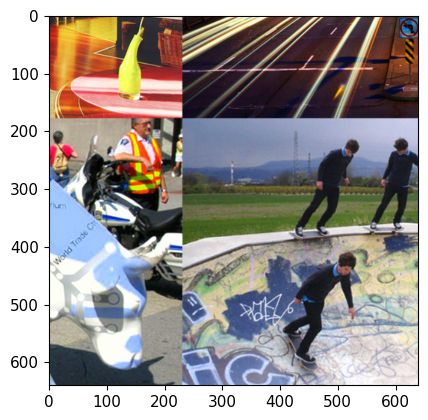

In [9]:
%matplotlib inline
plt.imshow(np.array(imgs[0].permute(1, 2, 0).cpu().numpy() * 255.0, dtype=np.uint8))
plt.show()

In [17]:
student_logits, student_features = student(imgs, distillation=True)
teacher_logits, teacher_features = model(imgs, distillation=True)

In [18]:
projectors = (
    nn.Conv2d(64, 160, 1, 1).to(device),
    nn.Conv2d(128, 320, 1, 1).to(device),
    nn.Conv2d(256, 640, 1, 1).to(device),
)
projected_student_features = []
for i, p in enumerate(projectors):
    projected_student_features.append(p(student_features[i]))
    

In [25]:
class ComputeFineGrainedFeatureImitationLoss:
    # From https://arxiv.org/abs/1906.03609
    def __init__(self, model, iou_threshold):
        super().__init__()
        self.iou_threshold = iou_threshold
        self.stride = model.stride
        det = model.model[-1]  # Detect() module
        for k in "na", "nc", "nl", "anchors", "anchor_grid":
            setattr(self, k, getattr(det, k))
        self.grid = [torch.zeros(1)] * det.nl
        self.grid_centers_x = []
        self.grid_centers_y = []

    @staticmethod
    def _make_grid(nx=20, ny=20):
        yv, xv = torch.meshgrid([torch.arange(ny), torch.arange(nx)], indexing="ij")
        return torch.stack((xv, yv), 2).view((1, 1, ny, nx, 2)).float()

    def __call__(self, student_features, teacher_features, teacher_pred, targets):
        # Compute targets
        # student_features: array of length num_detection_layers with tensors of shape (batch_size, num_channels, grid_size, grid_size)
        device = targets.device
        self.stride = self.stride.to(device)
        batch_size = student_features[0].shape[0]
        loss = torch.zeros(1, device=device)
        batch_ids = torch.arange(batch_size, dtype=torch.long).to(device)
        unique_batch_ids, unique_targets_per_image = targets[:, 0].unique(
            return_counts=True
        )
        # add zeros to ids that dont have any targets
        targets_per_image = torch.zeros(batch_size, dtype=torch.long, device=device)
        targets_per_image[unique_batch_ids.long()] = unique_targets_per_image.long()
        n_targets = targets_per_image.sum().item()
        targets, gj, gi = self.build_targets(teacher_pred, targets)  # targets
        anchors = self.anchors
        masks = []
        for i, pi in enumerate(teacher_pred):  # layer index, layer predictions
            grid_size_y = teacher_features[i].shape[-2]
            grid_size_x = teacher_features[i].shape[-1]

            anchors_i = torch.repeat_interleave(
                anchors[i], repeats=grid_size_y * grid_size_x, dim=0
            ).repeat(n_targets, 1)
            batch_ids_i = torch.repeat_interleave(
                batch_ids,
                repeats=targets_per_image * self.na * grid_size_y * grid_size_x,
                dim=0,
            )
            teacher_pred_i = torch.repeat_interleave(
                pi, repeats=targets_per_image, dim=0
            ).flatten(end_dim=-2)

            # Create an empty mask for each image in batch
            fgfi_mask = (
                torch.meshgrid(
                    [torch.zeros(grid_size_y), torch.zeros(grid_size_x)], indexing="ij"
                )[0]
                .unsqueeze(0)
                .repeat(batch_size, 1, 1)
                .clone()
                .to(device)
            )

            # Create grid
            if self.grid[i].shape[2:4] != teacher_features[i].shape[-2:]:
                self.grid[i] = self._make_grid(grid_size_y, grid_size_x).to(device)

            # Compute the predicted box coordinates in image space
            # The xy coordinates are relative to the grid cell center (offset)
            pxy = teacher_pred_i[:, :2].sigmoid() * 2.0 - 0.5
            pxy_image_space = (pxy + self.grid[i][0, 0, gj[i], gi[i]]) * self.stride[i]
            pwh = (
                (teacher_pred_i[:, 2:4].sigmoid() * 2) ** 2
                * anchors_i
                * self.stride[i].repeat(2)
            )
            pbox = torch.cat((pxy_image_space, pwh), 1)  # predicted box

            # Compute IOU between the target boxes and each prediction
            # In total for each layer we have BATCH_SIZE * N_ANCHORS * GRID_X * GRID_Y prediction
            iou = bbox_iou(
                pbox.T, targets[i], x1y1x2y2=False
            )  # iou(prediction, target)
            # Fill mask where the IOU is above the threshold
            fgfi_threshold = (
                iou.max(0)[0] * self.iou_threshold
            )  # foreground-background indicator mask
            iou_mask = iou > fgfi_threshold
            filtered_gi = gi[i][iou_mask]
            filtered_gj = gj[i][iou_mask]
            filtered_batch_items = batch_ids_i[iou_mask]
            fgfi_mask[filtered_batch_items, filtered_gj, filtered_gi] = 1.0

            # Compute losses
            N = fgfi_mask.sum()
            loss += (
                fgfi_mask
                * (
                    (
                        F.normalize(student_features[i])
                        - F.normalize(teacher_features[i])
                    )
                    ** 2
                ).sum(1)
            ).sum() / (2 * N)
            masks.append(fgfi_mask)
        # Average over batch size times the number of layers
        return loss / (3.0), masks

    def build_targets(self, p, targets):
        # Build targets for each anchor in each grid cell
        gain = torch.ones(6, device=targets.device).long()

        complete_targets = []
        for i in range(self.nl):
            # Transfer targets coordinates from 0-1 to 0-640
            gain[2:6] = torch.tensor([640, 640, 640, 640])
            t = targets * gain
            targets_repeats = p[i].shape[1] * p[i].shape[2] * p[i].shape[3]
            grid_indexes_repeats = p[i].shape[1] * targets.shape[0]
            t = torch.repeat_interleave(t, repeats=targets_repeats, dim=0)
            complete_targets.append(t[..., 2:].clone())
            
            if len(self.grid_centers_x) - 1 < i:
                # Create grid cell centers during the first run
                grid_y, grid_x = torch.meshgrid(
                    [torch.arange(p[i].shape[2]), torch.arange(p[i].shape[3])],
                    indexing="ij",
                )
                grid_y = (
                    grid_y.flatten()
                    .unsqueeze(0)
                    .repeat(grid_indexes_repeats, 1)
                    .long()
                    .flatten()
                    .clone()
                )
                grid_x = (
                    grid_x.flatten()
                    .unsqueeze(0)
                    .repeat(grid_indexes_repeats, 1)
                    .long()
                    .flatten()
                    .clone()
                )
                self.grid_centers_x.append(grid_x)
                self.grid_centers_y.append(grid_y)

        return complete_targets, self.grid_centers_y, self.grid_centers_x


In [26]:
loss_fn = ComputeLoss(student)
kd_loss_fn = ComputeKDLoss(student)
fgfi_loss_fn = ComputeFineGrainedFeatureImitationLoss(model, 0.4)

In [29]:
loss, mask = fgfi_loss_fn(projected_student_features, teacher_features, teacher_logits, targets)

In [17]:
pred_weight_mask = teacher_features[-3:]
for i in range(len(pred_weight_mask)):
    pred_weight_mask[i] = pred_weight_mask[i].abs().pow(2).sum(dim=1)
kd_loss_fn(student_logits, teacher_logits, pred_weight_mask)

(tensor([1.77062], device='cuda:0', grad_fn=<MulBackward0>),
 tensor([0.09629, 0.13008, 0.06874, 0.29510], device='cuda:0'))

In [43]:
fgfi_loss_fn.stride, fgfi_loss_fn.anchors.cpu() * fgfi_loss_fn.stride.view(-1,1).repeat(1, 2)

(tensor([ 8., 16., 32.]),
 tensor([[[ 12.00000,  16.00000],
          [ 38.00000,  72.00000],
          [160.00000, 112.00000]],
 
         [[ 18.00000,  37.50000],
          [ 76.00000,  55.00000],
          [144.00000, 292.00000]],
 
         [[ 35.50000,  27.50000],
          [ 96.00000, 121.50000],
          [459.00000, 401.00000]]]))

In [18]:
student.model[-1].stride, student.model[-1].anchors.cpu() * student.model[-1].stride.view(-1,1).repeat(1, 2)

(tensor([ 8., 16., 32.]),
 tensor([[[ 10.00000,  13.00000],
          [ 32.00000,  60.00000],
          [132.00000,  92.00000]],
 
         [[ 15.00000,  30.50000],
          [ 62.00000,  45.00000],
          [118.00000, 238.00000]],
 
         [[ 29.00000,  22.50000],
          [ 78.00000,  99.00000],
          [373.00000, 326.00000]]]))

In [68]:
bbox

tensor([[407.25092,   6.52268,  29.95037,  12.93013],
        [443.69775,   6.56056,  12.06466,  13.12535],
        [526.71771,   7.11885,  12.25570,  14.51601],
        ...,
        [401.10355, 555.66339,  23.80514,  19.67398],
        [621.33948,  62.40791,  36.96621,  87.20620],
        [556.69727, 112.17905, 137.37967,  23.08317]], device='cuda:0')

In [20]:
tbox[0]

tensor([0.82829, 0.84879, 3.63421, 1.69379], device='cuda:0')

In [101]:
iou

tensor([0.95344, 0.40555, 0.92364, 0.50068, 0.39002, 0.85623, 0.93352, 0.97706, 0.87301, 0.93705, 0.91962, 0.90339, 0.86712, 0.66414, 0.73702, 0.96047, 0.88229, 0.96119, 0.89645, 0.01016, 0.01273, 0.80872, 0.00984, 0.58084, 0.13077, 0.97414, 0.33093, 0.00928, 0.96677, 0.29666, 0.73212, 0.00962, 0.01143, 0.90304,
        0.98949, 0.95243, 0.93774, 0.98378, 0.16322, 0.93707, 0.93404, 0.95278, 0.93955, 0.55120, 0.92877, 0.82897, 0.93275, 0.08388, 0.95824, 0.88449, 0.75058, 0.40545, 0.92346, 0.85257, 0.93162, 0.98601, 0.87840, 0.93995, 0.92031, 0.90221, 0.87730, 0.65577, 0.95644, 0.88109, 0.95791, 0.89599, 0.78473, 0.57756,
        0.96898, 0.11229, 0.96717, 0.29468, 0.73771, 0.89993, 0.98784, 0.95113, 0.93723, 0.98155, 0.94038, 0.93954, 0.95649, 0.94465, 0.92018, 0.59610, 0.93139, 0.80216, 0.92868, 0.95807, 0.86379, 0.74153, 0.85484, 0.93484, 0.98505, 0.94733, 0.89493, 0.95942, 0.88501, 0.96284, 0.89302, 0.75896, 0.97522, 0.96470,
        0.98127, 0.94290, 0.98330, 0.94206, 0.94966, 0.955

In [535]:
def plot_pred(pred, conf, imgs, index, conf_thres=0.5):
    t_img = np.ascontiguousarray(np.array(imgs[index].cpu().numpy() * 255, dtype=np.uint8).transpose(1, 2, 0))
    for n, (i, j, w, h)in enumerate(pred):
        if conf[n].sigmoid() > conf_thres:
            t_img = cv2.rectangle(t_img, (int((i - w / 2).item()), int((j - h / 2).item())), (int((i + w / 2).item()), int((j + h / 2).item())), (0, 255, 0), 2)
    plt.imshow(t_img)

In [539]:
cv2.imwrite('test.jpg', np.ascontiguousarray(np.array(imgs[0].cpu().numpy() * 255, dtype=np.uint8).transpose(1, 2, 0))[...,::-1])

True

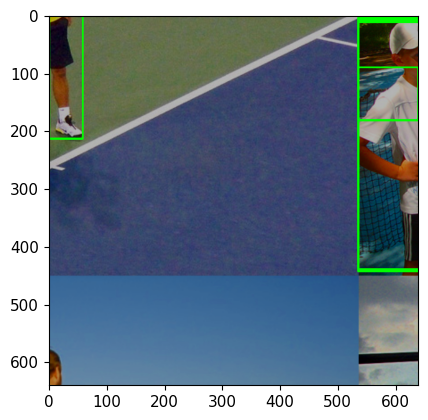

In [648]:
plot_pred(pred, conf, imgs, 3, conf_thres=0.1)

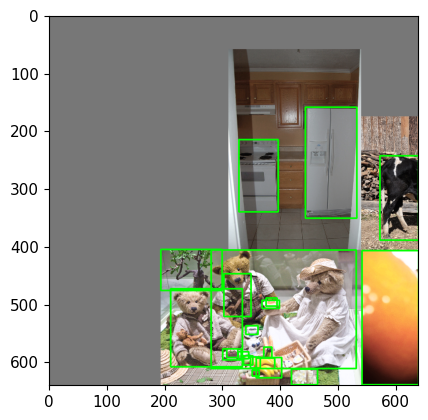

In [656]:
plot_pred(_targets, conf, imgs, 0)


In [34]:
def plot_mask(mask, imgs, index):
    t_img = np.ascontiguousarray(np.array(imgs[index].cpu().numpy() * 255, dtype=np.uint8).transpose(1, 2, 0))
    # resize mask to t_img size
    image_mask = []
    for i in range(3):
        image_mask.append(cv2.resize(mask[i][index].cpu().numpy(), (640, 640), interpolation=cv2.INTER_NEAREST))
    # sum all masks
    image_mask = np.sum(image_mask, axis=0)
    image_mask = np.array(np.clip(image_mask, 0, 1), dtype=np.uint8) * 255
    plt.imshow(cv2.addWeighted(t_img,0.5,np.expand_dims(image_mask, 2).repeat(3, axis=2),0.5, 0))

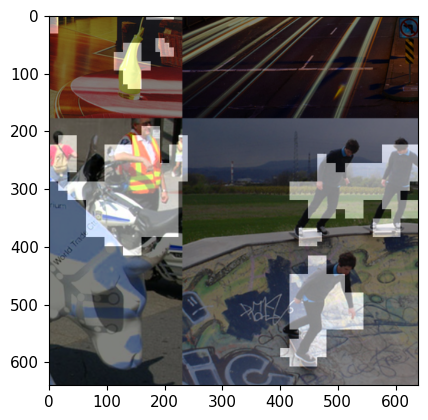

In [35]:
plot_mask(mask, imgs, 0)

In [123]:
for (i, j, w, h), _iou in zip(bbox, iou):
    # grid = make_grid(20, 20).to(device)
    # i = int(i.item())
    # j = int(j.item())
    # i,j = torch.tensor([i,j]).to(device) + grid[0,0,i,j] * model.stride[2]
    if _iou > 0.5:
        t_img = cv2.circle(t_img, (int(i.item()), int(j.item())), 20, (0, 255, 0), -1)
        # t_img = cv2.rectangle(t_img, (int((i - w / 2).item()), int((j - h / 2).item())), (int((i + w / 2).item() ), int((j + h / 2).item())), (0, 255, 0), 2)

In [129]:
# for i, j, w, h in targets[torch.where(targets[:, 0] == 0)][:,2:]:
#     t_img = cv2.rectangle(t_img, (int((i - w / 2).item()*640), int((j - h / 2).item()*640)), (int((i + w / 2).item() * 640), int((j + h / 2).item() * 640)), (0, 255, 0), 2)
for i, j, w, h in tbox:
    t_img = cv2.rectangle(t_img, (int((i - w / 2).item()*640), int((j - h / 2).item()*640)), (int((i + w / 2).item() * 640), int((j + h / 2).item() * 640)), (0, 255, 0), 2)

In [159]:
for i, j in points:
    t_img = cv2.circle(t_img, (int(i.item()), int(j.item())), 20, (0, 255, 0), -1)


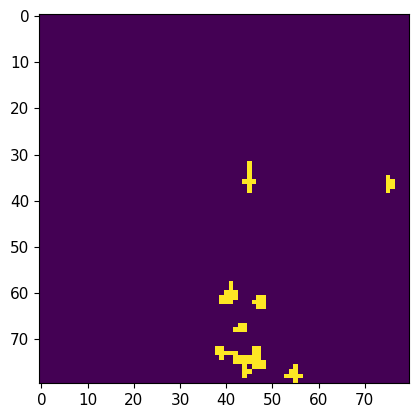

In [650]:
plt.imshow(mask[0][0])
plt.show()

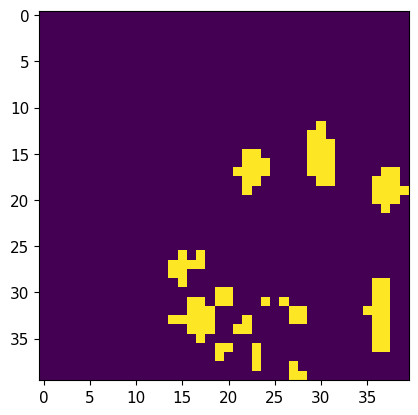

In [651]:
plt.imshow(mask[1][0])
plt.show()

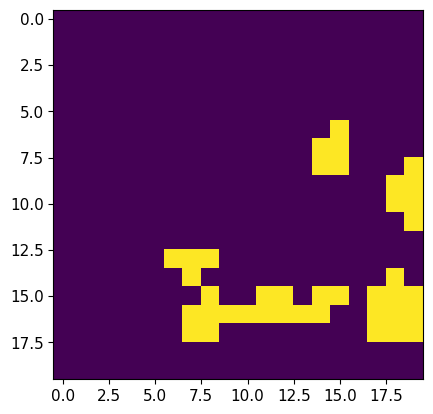

In [652]:
plt.imshow(mask[2][0])
plt.show()

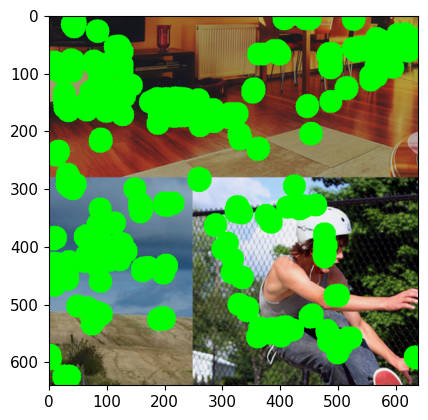

In [160]:
plt.imshow(t_img)
plt.show()

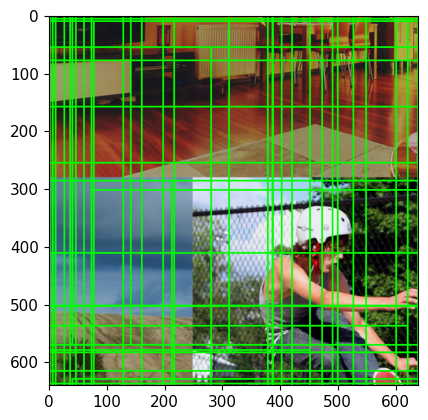

In [130]:
plt.imshow(t_img)
plt.show()